# Iris dataset

In this notebook we are going to research the "Fisher's Iris" dataset, we'll learn a classification model and measure it's quality.

During the code execution there'll be places, where we need to input our code. This sections will be taged like:

###YOUR CODE HERE ###

...

###YOUR CODE HERE ###

Inside this section we need to write code to compele tasks.

## Preparetion

In [28]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [29]:
# Set graphic's style
sns.set(style='whitegrid', font_scale=1.3)
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['legend.frameon'] = True

In [30]:
# Fix a random number generator for reproducibility of the experiment
np.random.seed(21)
torch.manual_seed(21);

## Reading data

Iris dataset really popular "start" dataset in ML environment. So we can take it not from downloading, but from Sklearn dataset. 

In [31]:
iris = load_iris()

Detail describing of the dataset and the features

In [32]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Total:

* Each object (flower) of our data has **4 attributes**
* We want to predict which of the **3 classes** (flower type) the object (flower) belongs to

In [33]:
n_features = 4 # number of features
n_classes = 3  # number of classes

Creating a table (pandas.DataFrame) with objects in rows and their features in the columns

In [34]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

Data example

In [35]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [36]:
y[:5]

array([0, 0, 0, 0, 0])

Statistics on data. It is useful to look at them to understand what features we have in general

In [37]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


All the features in our dataset are continuous numerical features

We will also look at the class names so that we can further interpret them consciously.

In [38]:
class_labels = iris.target_names
class_labels

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's also look at the matrix of correlations between the features

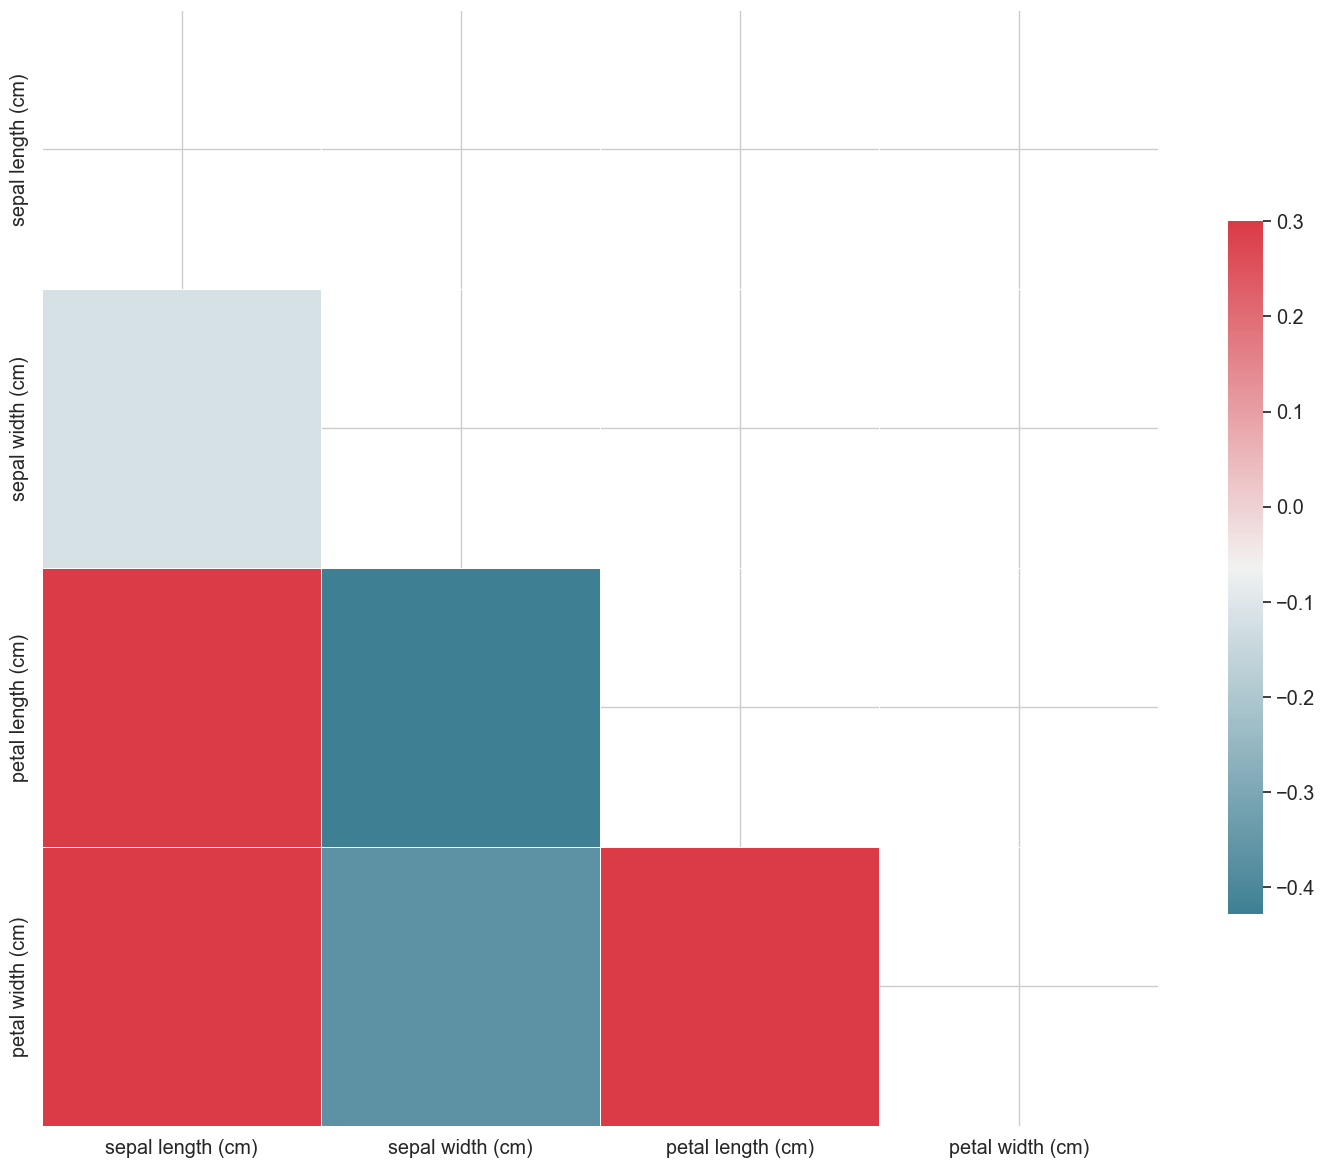

In [39]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Sometimes it also makes sense to look at pairwise distributions of features. In some cases, this analysis makes it more clear the nature of classes and how to build a classifier correctly.

In [ ]:
sns.pairplot(sns.load_dataset("iris"), hue="species", size=4);

As you can see from the graph above, one class (setosa) separates from the others very well. This means that even the simplest linear classifier will be able to separate it without errors. The other two classes are also separated quite well, but still overlap. Here, the linear classifier should also be good, but the neural network, presumably, will help to do even better.

Thus, we expect a very high classification quality from the model.

# Data preprocessing

## Spliting

Let's split our data into training and validation samples in the proportion of $\frac{4}{1}$

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=21)

## Create tensors

PyTorch requires its own type of vectors, which is called a tensor and is slightly different from the format in Numpy

In [66]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float)
X_valid_tensor = torch.tensor(np.array(X_valid), dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

We will also define the basic constants from the data to use them in the future

In [68]:
n_data = len(X_train_tensor)
n_data

120

# Models

## Baseline: Sklearn Logistic Regression

In order to have a quality value, from which you can start further in comparing models, it is customary to first make the simplest basic model. It is called the baseline. Here, as a baseline, we will take a linear classification model from the Sklearn library.

Note that although the model is called **logistic regression**, it solves the problem of **classification**. There is no mistake here.

In [69]:
model_lr_sklearn = LogisticRegression(C = 1e8,
                                      max_iter=5000,
                                      solver="sag",
                                      multi_class="multinomial")

Training model

In [70]:
model_lr_sklearn.fit(X_train, y_train)

LogisticRegression(C=100000000.0, max_iter=5000, multi_class='multinomial',
                   solver='sag')

Evaluating the quality

In [71]:
print("Train accuracy: {:.1f}%".format(model_lr_sklearn.score(X_train, y_train) * 100))
print("Valid accuracy: {:.1f}%".format(model_lr_sklearn.score(X_valid, y_valid) * 100))

Train accuracy: 99.2%
Valid accuracy: 96.7%


The linear classifier, as expected, works quite well here.

## PyTorch

In the practical part of the lecture, during the training of the model, we "walked" through the data manually using for loops.

In reality, this is rarely done, and most often they use existing utilities for data in PyTorch. [Link](https://pytorch.org/docs/stable/data.html ). This allows you not to reinvent the wheel, but to use standard methods for splitting into butches, random shuffling of data and much more. In the case of simple and small data that fits completely into RAM, this may not seem so relevant. But in reality, you almost always have to work with a large amount of data that you have to read from disk in chunks - it's not so easy to do it yourself with your hands. And very often the model is so large that it needs to be trained on several computers - and the independent implementation of this would take too much time and effort.

Considering all of the above, let's use the standard `Dataset` and `DataLoader` classes from PyTorch

In [72]:
from torch.utils.data import TensorDataset, DataLoader

In general, a `Dataset` is an abstraction over a dataset with data, with which you can do various operations. For example, index access to a specific object, calculation of the dataset length, etc. In our case, these operations are trivial and so, but remember that the data can be much more complex, consist of several pieces and be read from different places from the disk.

In our case, we already have data in the form of a tensor, so we will use the simplest dataset - `TensorDataset'.

In [73]:
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_valid = TensorDataset(X_valid_tensor, y_valid_tensor)

In [74]:
len(dataset_train)

120

Access by index `i` gives the value of the `i`-th element of the dataset - the values of both features and class

In [75]:
dataset_train[14]

(tensor([6.9000, 3.1000, 5.1000, 2.3000]), tensor(2))

To simplify the iteration of the dataset, we will use `DataLoader'. It allows you to do all the complex operations (and more) that were described earlier. Now we need only the simplest options - splitting into butches and mixing data at the training stage.

In [76]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=16, shuffle=True)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=16, shuffle=False)

Now iterating through the butches can be very simple:

In [80]:
for b in dataloader_train:
    break

In [81]:
b

[tensor([[7.3000, 2.9000, 6.3000, 1.8000],
         [6.2000, 2.8000, 4.8000, 1.8000],
         [4.9000, 3.1000, 1.5000, 0.2000],
         [5.7000, 4.4000, 1.5000, 0.4000],
         [6.3000, 3.4000, 5.6000, 2.4000],
         [5.8000, 2.8000, 5.1000, 2.4000],
         [5.1000, 3.5000, 1.4000, 0.2000],
         [5.4000, 3.7000, 1.5000, 0.2000],
         [5.5000, 2.4000, 3.8000, 1.1000],
         [6.3000, 2.9000, 5.6000, 1.8000],
         [5.4000, 3.4000, 1.5000, 0.4000],
         [4.8000, 3.4000, 1.6000, 0.2000],
         [5.6000, 2.9000, 3.6000, 1.3000],
         [7.2000, 3.2000, 6.0000, 1.8000],
         [5.9000, 3.2000, 4.8000, 1.8000],
         [5.5000, 2.6000, 4.4000, 1.2000]]),
 tensor([2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1, 1])]

## Metrics

We will evaluate our model by two metrics:
* CCE (Categorical Cross Entropy)
* Accuracy

In [82]:
def accuracy_loss(input, target):
    return torch.mean((np.argmax(input, axis=1) == target).type(torch.float)) * 100

We will also define the error function according to which we will train the model. In our case, this is CCE.

In [83]:
loss_func = nn.CrossEntropyLoss()

Let's set a set of metrics that we want to track

In [84]:
metrics_func = [loss_func, accuracy_loss]
metrics_name = ["CCE", "Accuracy"]

Let's define a function for evaluating the quality of one model on a given dataset by given metrics

In [85]:
def evaluate(model, metrics_func, X, y):
    metrics_value = []
    with torch.no_grad():
        preds = model(X)
        for metric_func in metrics_func:
            metric_value = metric_func(preds, y)
            metrics_value.append(metric_value)
    return metrics_value

### Task: Logistic regression

The Logistic Regression model can be considered as a simple neural network without hidden layers and without activation functions.

The number of features in our Iris dataset is 4. Therefore, the input layer has 4 neurons. We want to predict the number of the class to which the object belongs. We have 3 classes in total. Therefore, there will be 3 output neurons - each neuron shows the probability of belonging to each of the classes. As a result, the object will belong to the class whose probability is greater.

Your task is to create the described neural network model using PyTorch.

(For example, you can look at the notebook from the practical part of the lecture)

In [120]:
%%time

model_lr = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=n_classes),
)

CPU times: user 849 µs, sys: 2.43 ms, total: 3.28 ms
Wall time: 6.22 ms


For training, we will use the simplest gradient method of step-by-step optimization - Batch Gradient Descent.

In [121]:
opt_lr = optim.SGD(params=model_lr.parameters(), lr=0.01)

We train the model.

Your task here is to enter the missing steps in the learning cycle.

At the same time, evaluate how much simpler the training code using `DataLoader` is than the code written by hand in the practical part of the lecture.

In [123]:
%%time

epochs_lr = 1500
history_lr_train = []
history_lr_valid = []

for epoch in tqdm(range(epochs_lr)):
    # forming of data batches
    for Xb, yb in dataloader_train:

        # forward pass: making prediction
        y_pred = model_lr(Xb)

        # forward pass: calculating loss
        loss = loss_func(y_pred, yb)

        # backward pass: calculating gradients
        loss.backward()

        # weights update
        opt_lr.step()
        opt_lr.zero_grad()

    history_lr_train.append(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor))
    history_lr_valid.append(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor))

history_lr_train = np.array(history_lr_train)
history_lr_valid = np.array(history_lr_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 2.2 s, sys: 325 ms, total: 2.53 s
Wall time: 2.46 s


Let's draw how the error function changed in the course of training

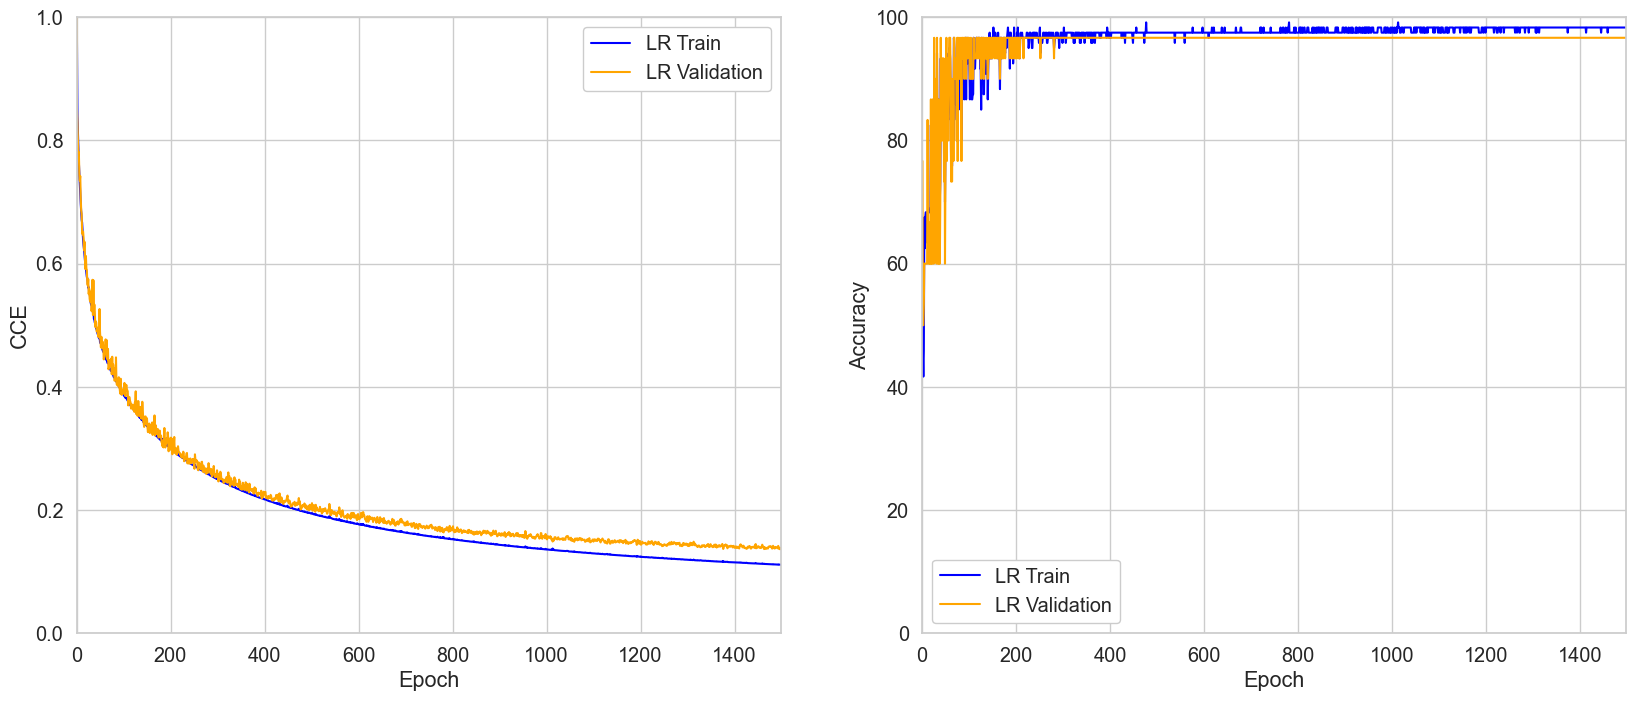

In [124]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Final metrics

In [125]:
print("Train accuracy: {:.1f}%".format(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor)[1].item()))
print("Valid accuracy: {:.1f}%".format(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor)[1].item()))

Train accuracy: 98.3%
Valid accuracy: 96.7%


Let's see where we make mistakes most often - for this we will draw a matrix of predictions and errors.

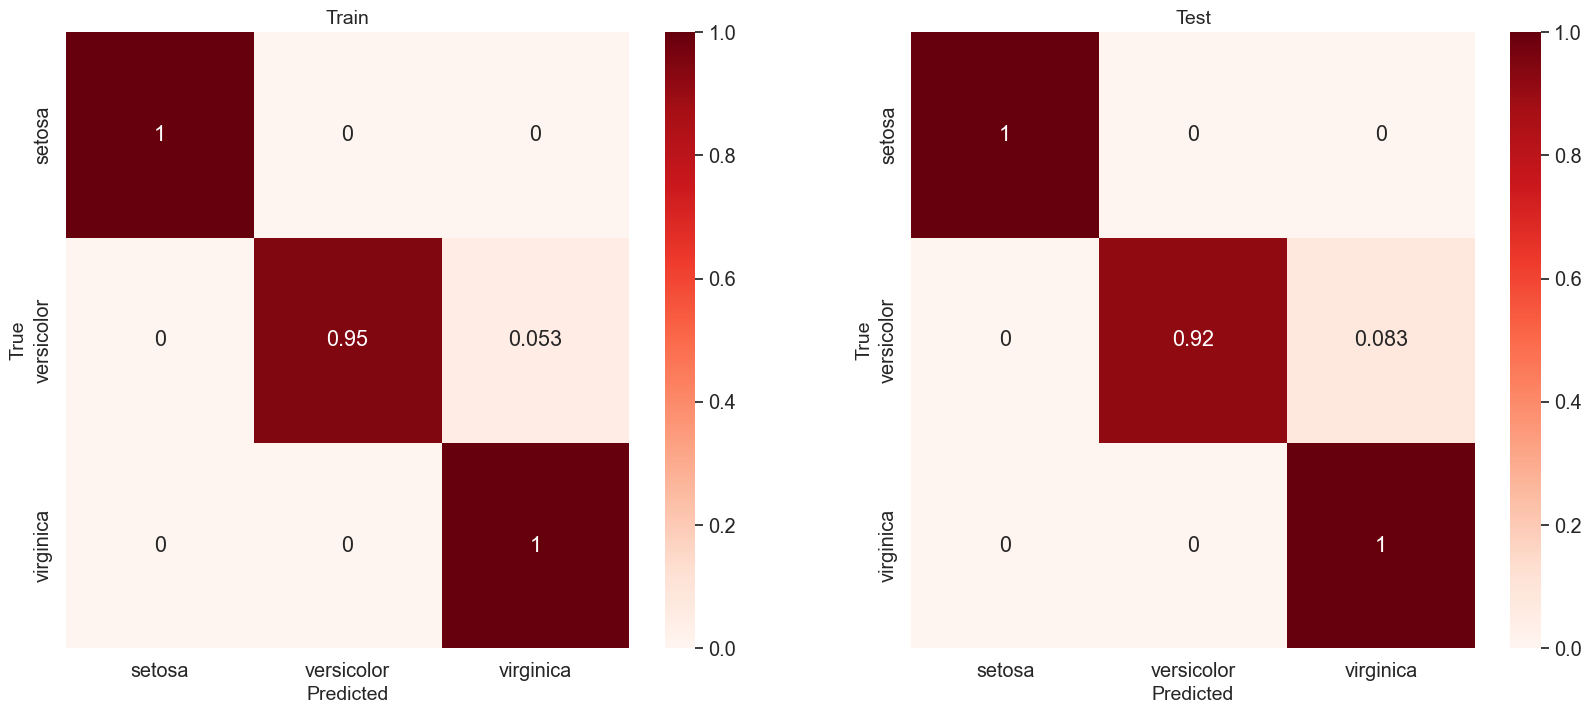

In [126]:
with torch.no_grad():
    preds_train = model_lr(X_train_tensor)
    preds_valid = model_lr(X_valid_tensor)
    preds_train = np.argmax(preds_train, axis=1)
    preds_valid = np.argmax(preds_valid, axis=1)

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_valid = confusion_matrix(y_valid, preds_valid).astype(np.float32)
cm_valid /= cm_valid.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_valid, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

### Task: MLP with 3 hidden layers

Now we define a more complex model with 2 hidden layers and a ReLU activation function.

![relu image](https://analyticsindiamag.com/wp-content/uploads/2018/01/relu-activation-function-1.png)

Your task is to create a neural network with the following architecture

* The first hidden layer is 16 neurons
* Activation function - ReLU
* The second hidden layer - 32 neurons
* Activation function - ReLU

(For example, you can look at the laptop from the practical part of the task)

In [129]:
### YOUR CODE HERE ###
model_mlp_3 = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=n_classes)
)
### YOUR CODE HERE ###

The setting for learning is the same as before, except for a smaller learning_rate

In [130]:
opt_mlp_3 = optim.SGD(params=model_mlp_3.parameters(), lr=0.002)

We train the model. 

Your task here is to enter the missing steps in the learning cycle.

At the same time, evaluate how much simpler the training code using `DataLoader` is than the code written by hand in the practical part of the lecture.

In [131]:
%%time

epochs_mlp_3 = 1500
history_mlp_3_train = []
history_mlp_3_valid = []

for epoch in tqdm(range(epochs_mlp_3)):
    # forming data batches
    for Xb, yb in dataloader_train:

        # forward pass: making prediction
        ### YOUR CODE HERE ###
        pred = model_mlp_3(Xb)
        ### YOUR CODE HERE ###

        # forward pass: calculating loss
        ### YOUR CODE HERE ###
        loss = loss_func(pred, yb)
        ### YOUR CODE HERE ###

        # backward pass: calculate gradients
        ### YOUR CODE HERE ###
        loss.backward()
        ### YOUR CODE HERE ###

        # weights update
        ### YOUR CODE HERE ###
        opt_mlp_3.step()
        opt_mlp_3.zero_grad()
        ### YOUR CODE HERE ###

    history_mlp_3_train.append(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor))
    history_mlp_3_valid.append(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor))

history_mlp_3_train = np.array(history_mlp_3_train)
history_mlp_3_valid = np.array(history_mlp_3_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 3.49 s, sys: 438 ms, total: 3.93 s
Wall time: 3.75 s


Let's draw how the error function changed during training and compare it with the previous model (PyTorch Logistic Regression)

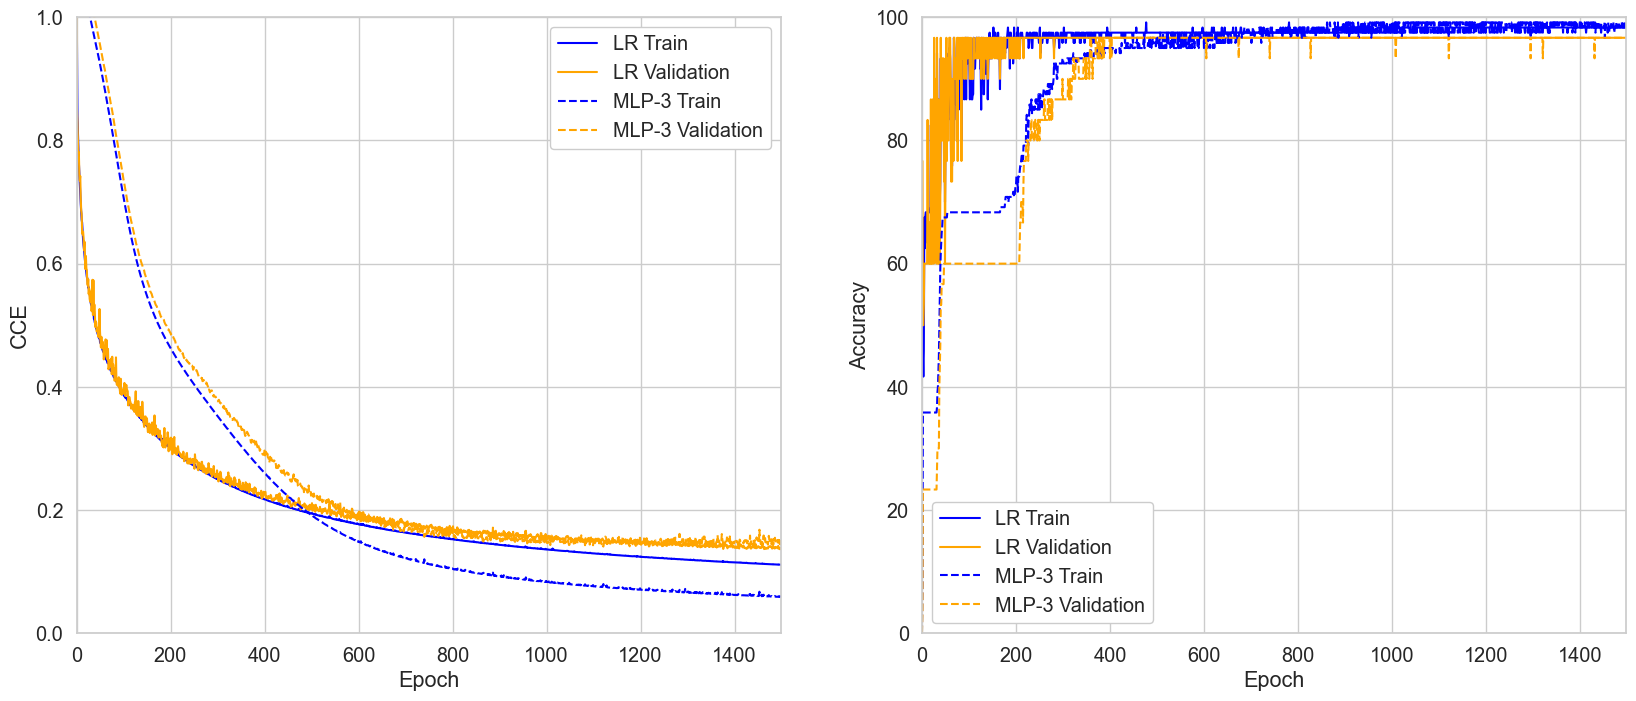

In [132]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 0], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 0], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 1], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 1], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Final metrics

In [133]:
print("Train accuracy: {:.1f}%".format(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor)[1].item()))
print("Valid accuracy: {:.1f}%".format(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor)[1].item()))

Train accuracy: 99.2%
Valid accuracy: 96.7%


Let's see where we make mistakes most often - for this we will draw a matrix of predictions and errors.

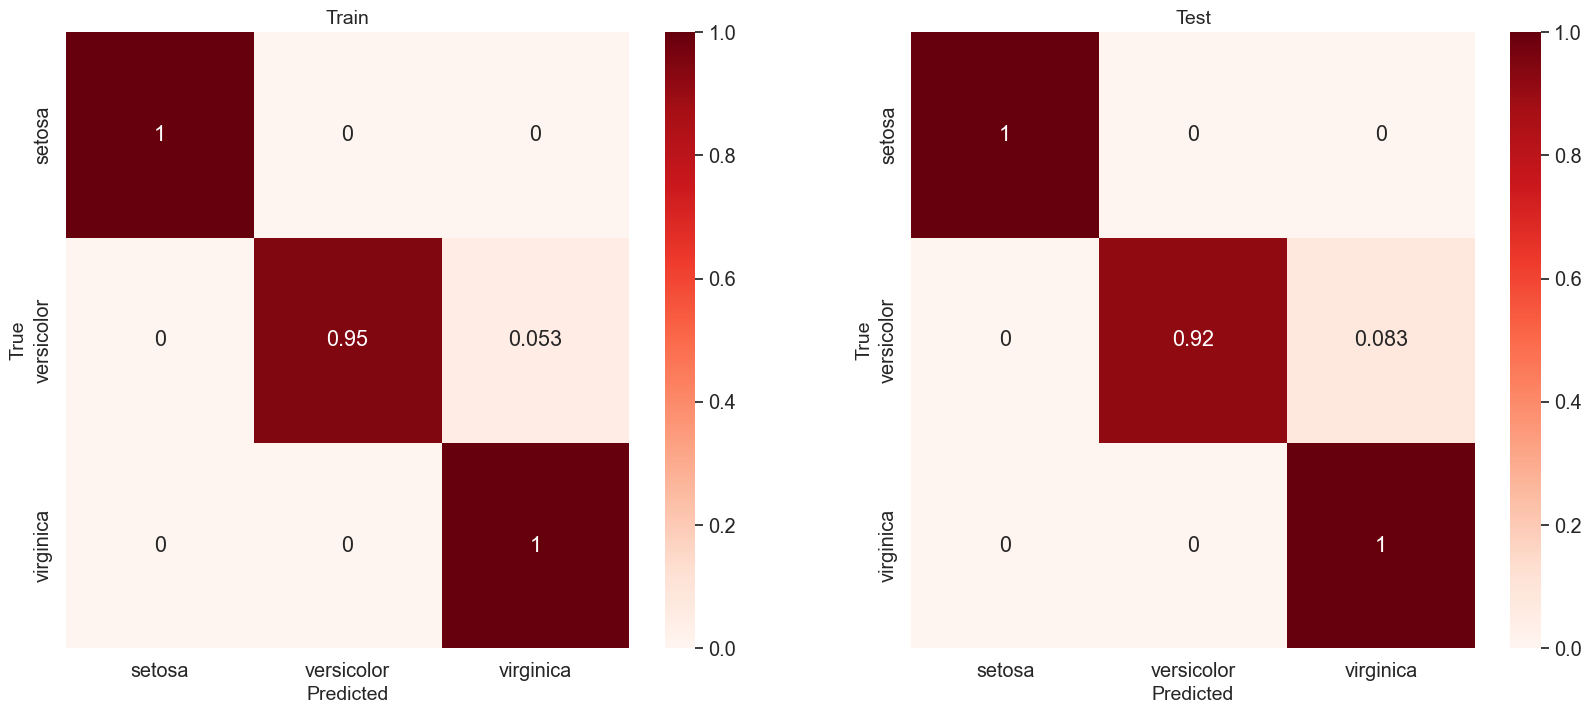

In [134]:
with torch.no_grad():
    preds_train = model_lr(X_train_tensor)
    preds_valid = model_lr(X_valid_tensor)
    preds_train = np.argmax(preds_train, axis=1)
    preds_valid = np.argmax(preds_valid, axis=1)

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_valid = confusion_matrix(y_valid, preds_valid).astype(np.float32)
cm_valid /= cm_valid.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_valid, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

# Questions

1. Do the results obtained and the quality of the model coincide with what was expected after the preliminary data analysis stage? If not, why not?

Yes, they match. The setosa class, as expected, separated perfectly even by the simplest model. There are small errors among the other two classes, due to the fact that the classes overlap.

2. Does a multilayer model have a strong advantage over a simple linear one? Explain why.

No, not strong. There is almost no difference in quality between the multilayer and linear models.

This is due to the fact that the data is quite simple and even by eye they can be easily classified. Therefore, the linear classifier copes well.

3. Which model would you choose to run in production?

In this case, a simple model with the same quality is preferable - that is, logistic regression.

This is because, other things being equal, other factors besides quality are important in production: speed, ease of support, consumed resources. All these indicators are the better, the simpler the model.

As for whether to choose a model on Sklearn or on PyTorch is a matter of the technology stack used in the team and ease of further use in the company.

4. Is data normalization needed here? If you add it, will the quality change? Why / why not?

Although the initial signs are not in some pre-limited range, they are still all of a fairly similar and small scale - everything from 0 to 10. Therefore, normalization will not significantly improve the quality of the model, but it will not be superfluous to add it.